<a href="https://colab.research.google.com/github/ngzhankang/Deep-Learning/blob/main/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1
Submitted by : P1935727 Ng Zhan Kang<br>
Class of DIT/FT/2B/11


---
---

# 1.Setting Up Working Environment In Google Colab

### 1.1 Ensuring 0% Util

---

Ensure that our slot give by Google is not utilized yet.

In [1]:
# to ensure that the current gpu utilization is 0
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

Gen RAM Free: 12.8 GB  | Proc size: 112.0 MB
GPU RAM Free: 15079MB | Used: 0MB | Util   0% | Total 15079MB


### 1.2. Forcing Utils To 0%

---

Please do not use this step unless forced to.

In [2]:
# if utilization is > 0, run this code(keep running this cell and the above cell till the util number is 0%):
# NOTE THAT RUNNING THIS MIGHT KILL GPU SESSION AND RESULT IN DATA LOSS(NOT ADVICABLE TO KEEP ON REUSING)
# !kill -9 -1

---
---

# 2.Ensuring GPU Is Utilized In Environment

### 2.1. See the list of available devices

---

This entire section can be omitted if users are not utilizing GPU at all.

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11299080425223712135
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 6522187117949926473
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 16576541693336094887
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14640891840
locality {
  bus_id: 1
  links {
  }
}
incarnation: 509756032009380385
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [4]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
tf.test.gpu_device_name()

'/device:GPU:0'

---
---

# 3.About The MNIST Dataset (Background Information)

## 3.1. Background
- The MNIST database(Modified National Institute of Standards and Technology database) history came to existence by 
- The MNIST database of handwritten digits, available from this page, has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image.

## 3.2. Classic MNIST Dataset
- For this problem, use only 1 target output variable (Survived)
- Prepare the data and perform necessary feature engineering
- Create **_at least two models_** 
- Evaluate the models and pick the best candidate
- Form some conclusions

---
---

# 4.Data Importing

### 4.1. Load the libraries

---

Import the necessary libraries.

In [6]:
# Suppress Future Warnings
import warnings
warnings.filterwarnings('ignore')

In [7]:
# check versions of libraries we are going to use
%tensorflow_version 2.x
import os
import tensorflow
import kerastuner
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import platform

message="        Versions        "
print("*"*len(message))
print(message)
print("*"*len(message))
print("Tensorflow version={}".format(tensorflow.__version__))
print("KerasTuner version={}".format(kerastuner.__version__))
print("Numpy version={}".format(np.__version__))
print("Pandas version={}".format(pd.__version__))
print("Seaborn version={}".format(sns.__version__))
print("Matplotlib version={}".format(matplotlib.__version__))
print("Python version={}".format(platform.python_version()))

************************
        Versions        
************************
Tensorflow version=2.3.0
KerasTuner version=1.0.1
Numpy version=1.18.5
Pandas version=1.1.3
Seaborn version=0.11.0
Matplotlib version=3.2.2
Python version=3.6.9


In [8]:
# start importing necessary libraries
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from tensorflow.python.keras.callbacks import EarlyStopping
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

In [9]:
# fix random seed so that we do not see variation in accuracy each time we run thru 
seed_value = 88
np.random.seed(seed_value)

# get the dataset from keras library in tensorflow 2.0
mnist = tf.keras.datasets.mnist

# unpack the dataset to the respective x_train, y_train, x_test and y_test
(x_train, y_train), (x_test, y_test) = mnist.load_data()

### 4.2. Verify the dataset

---

Verify the credibility of the dataset first by plotting the 1st 25 images from the training set and display the class name below each image.

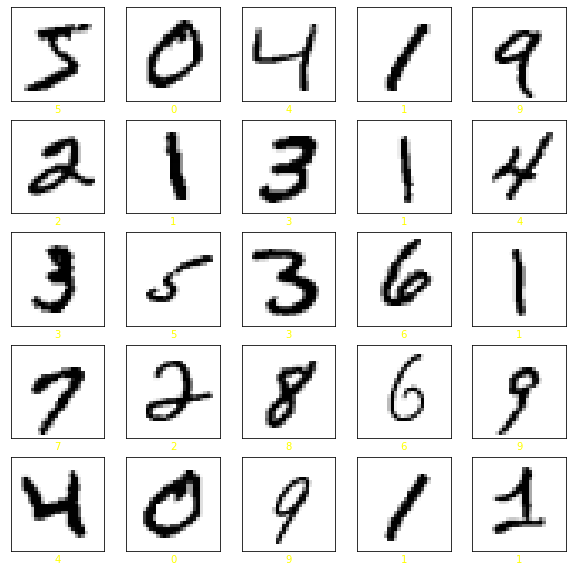

In [10]:
numbers = ['0','1','2','3','4','5','6','7','8','9']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(numbers[y_train[i]], color="yellow")
plt.show()

<div class="alert alert-block alert-info">
    <b>Analysis Summary:</b> It seems that the labels matches all the images, which is good! Now let's carry on to get a better insight of the datatset we are going to deal with.<p>
</div>

---
---

# 5.Exploratory Data Analysis

### 5.1. Basic Data Exploration

---

Take a peek look at what is inside the `x_train` and the `x_test`.

In [11]:
# take a look at the x_train set first
print(x_train.shape)
print(y_train.shape)

(60000, 28, 28)
(60000,)


In [12]:
# take a look at the x_test set
print(x_test.shape)
print(y_test.shape)

(10000, 28, 28)
(10000,)


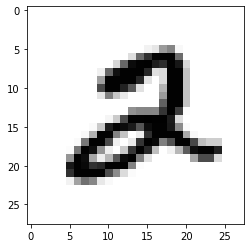

In [13]:
# grab a random picture to take a look
plt.imshow(x_train[5], cmap=plt.cm.binary)
plt.show()

In [14]:
# get the distinct lables that are found in the entire thing
print('Training set unique labels:',np.unique(y_train))
print('Test set unique labels:',np.unique(y_test))

Training set unique labels: [0 1 2 3 4 5 6 7 8 9]
Test set unique labels: [0 1 2 3 4 5 6 7 8 9]


In [15]:
# get the count of the values from 0 to 9
unique, counts = np.unique(y_train, return_counts=True)
print(np.asarray((unique, counts)).T)

[[   0 5923]
 [   1 6742]
 [   2 5958]
 [   3 6131]
 [   4 5842]
 [   5 5421]
 [   6 5918]
 [   7 6265]
 [   8 5851]
 [   9 5949]]


---
---

# 6.Feature Engineering

### 6.1. Changing Dimension To Match Keras Expectation

---

Reshape `x_train` and `x_test` to 4 dimensional array for the convolutional layer later on.

In [16]:
# see the shape of x_train and x_test first
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28)
60000 train samples
10000 test samples


In [17]:
# flatten 28*28 images to a 784 vector for each image
num_pixels = x_train.shape[1] * x_train.shape[2]
x_train = x_train.reshape(x_train.shape[0], num_pixels).astype('float32')
x_test = x_test.reshape(x_test.shape[0], num_pixels).astype('float32')

In [18]:
# see the changes
print('New x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

New x_train shape: (60000, 784)
60000 train samples
10000 test samples


In [19]:
# # reshape x_train and x_test to (n_images, x_shape, y_shape, channels)
# # we are going to make chanels be 1 as we are not dealing with rgb images.
# x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
# x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

### 6.2. Normalize Training Data

---

Normalize the entire training dataset so that there is not much variation.

In [20]:
# attempt to normalize the entire dataset first from 0-255 to 0-1
x_train = x_train / 255
x_test = x_test / 255

### 6.3. Convert To Categorical Data

---

Convert the labels to categorical data as we do not want the model to think 9 has a higher priority than 0.

In [21]:
# see what does actually 1 label for the training dataset looks like in a numpy array
# get the one from the 1st image
print(y_train[0])

5


In [22]:
# see what does actually 1 label for the test dataset looks like in a numpy array
# get the one from the 1st image
print(y_test[0])

7


In [23]:
# use to_categorical to convert the training and testing dataset labels
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)
num_classes = y_test.shape[1]

In [24]:
# now lets check again the training dataset labels
print(y_train[0])

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [25]:
# now lets check again the testing dataset labels
print(y_test[0])

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


---
---

# 7.Models

### 7.1. Baseline Model

---

First, we will setup a baseline model first using Keras Sequential Model.

In [26]:
# create model and give it a name
model = Sequential(name="baseline_model_sequential")

# add 1st fully connected layer (hidden layer)
model.add(Dense(num_pixels, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))

# add 2nd fully connected layer (hidden layer)
model.add(Dense(256,  kernel_initializer='normal', activation=tf.nn.relu))

# add 3rd fully connected layer (hidden layer)
model.add(Dense(128,  kernel_initializer='normal', activation=tf.nn.relu))
model.add(Dropout(0.5)) # add a dropout layer to drop out some neurons during training to prevent overfitting

# add output layer
model.add(Dense(num_classes, kernel_initializer='normal', activation=tf.nn.softmax))

# model summary
model.summary()

Model: "baseline_model_sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 784)               615440    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 850,586
Trainable params: 850,586
Non-trainable params: 0
_________________________________________________________________


In [27]:
# time to optimise the empty baseline model(an empty shell basically) and fit it with our training dataset
# passing params into the newly created model and compile it
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

# train the model
history = model.fit(x_train, y_train, validation_split=0.2, epochs=15, batch_size=200, verbose=1)

Epoch 1/15
240/240 [==============================] - 1s 5ms/step - loss: 0.4056 - accuracy: 0.8801 - val_loss: 0.1357 - val_accuracy: 0.9588
Epoch 2/15
240/240 [==============================] - 1s 4ms/step - loss: 0.1362 - accuracy: 0.9603 - val_loss: 0.1025 - val_accuracy: 0.9684
Epoch 3/15
240/240 [==============================] - 1s 4ms/step - loss: 0.0882 - accuracy: 0.9745 - val_loss: 0.0928 - val_accuracy: 0.9724
Epoch 4/15
240/240 [==============================] - 1s 4ms/step - loss: 0.0621 - accuracy: 0.9819 - val_loss: 0.0823 - val_accuracy: 0.9768
Epoch 5/15
240/240 [==============================] - 1s 4ms/step - loss: 0.0473 - accuracy: 0.9859 - val_loss: 0.0909 - val_accuracy: 0.9751
Epoch 6/15
240/240 [==============================] - 1s 4ms/step - loss: 0.0335 - accuracy: 0.9904 - val_loss: 0.0867 - val_accuracy: 0.9778
Epoch 7/15
240/240 [==============================] - 1s 4ms/step - loss: 0.0269 - accuracy: 0.9921 - val_loss: 0.0839 - val_accuracy: 0.9787
Epoch 

In [29]:
#print the available history keys for use
print(history.history.keys()) 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


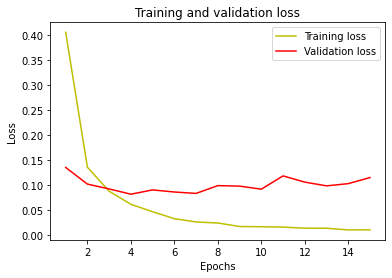

In [30]:
# plot a accuracy and validation loss graph to see the training and validation loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

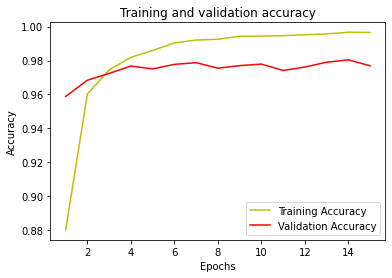

In [31]:
# plot a accuracy and validation accuracy graph to see the training and validation accuracy at each epoch
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(epochs, accuracy, 'y', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### 7.2. CNN Model

---

Next, we will setup a CNN Model.

In [ ]:

# Compile model
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', metrics=['accuracy'])

# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), 
          epochs=10, batch_size=200, verbose=2)

# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

---
---

# 8.Test Accuracy, Loss And Results

### 8.1. Baseline Model Result

---

Get the result for the baseline model.

In [35]:
# now we shall evaluate the model and see the accuracy
score = model.evaluate(x_test,y_test, verbose=1)
print("Test loss:", score[0])
print("Test accuracy:", score[1])
print("BaseLine Model Error: %.2f%%" % (100-score[1]*100))

313/313 [==============================] - 1s 3ms/step - loss: 0.1039 - accuracy: 0.9790
Test loss: 0.10394082218408585
Test accuracy: 0.9789999723434448
BaseLine Model Error: 2.10%


Actual Label: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Predicted Number: 5


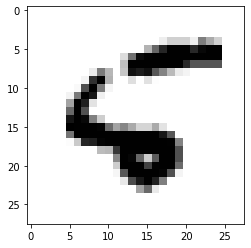

In [42]:
# get a random index which we will use it to see what number it is from the test dataset(it shld be a number all the way to 60,000)
image_index = 8

# see what image it is first
plt.imshow(x_test[image_index].reshape(28, 28),cmap=plt.cm.binary) # visually, we identify the number as 6
# see the actual label
actual_label = (y_test[image_index])
print('Actual Label:', actual_label)

# now lets try to feed the image_index into x_test and feed it into the trained model
pred = model.predict(x_test[image_index].reshape(1,-1)) # changing it to a 1d array first
print('Predicted Number:', pred.argmax()) # print out the result